In [ ]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.
Step 1: Forecasting the future of key economic drivers...
  - Forecasting GC_US_10g...


12:50:02 - cmdstanpy - INFO - Chain [1] start processing
12:50:02 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing


  - Forecasting USD=INR...


12:50:05 - cmdstanpy - INFO - Chain [1] start processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing
12:50:05 - cmdstanpy - INFO - Chain [1] done processing


  - Forecasting cpi_inflation_ind...


12:50:06 - cmdstanpy - INFO - Chain [1] start processing
12:50:06 - cmdstanpy - INFO - Chain [1] done processing
12:50:06 - cmdstanpy - INFO - Chain [1] done processing


Key driver forecasts complete.

Step 2: Training main model with multiple features...


C:\Users\Sanika\AppData\Local\Temp\ipykernel_11848\1686443010.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future[regressor] = regressor_forecasts[regressor]['yhat']
C:\Users\Sanika\AppData\Local\Temp\ipykernel_11848\1686443010.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future[regressor] = regressor_forecasts[regressor]['yhat']
C:\Users\Sanika\AppData\Local\Temp\ipykernel_11848\1686443010.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Main model training complete.

Step 3: Saving model and data files...
 - Model saved to 'gold_price_prophet_model.pkl'
 - Model saved to 'gold_price_prophet_model.json'
 - Input data saved to 'model_input_data.json'
 - Forecast data saved to 'model_output_forecast.json'

Step 4: Plotting the final 5-year forecast...


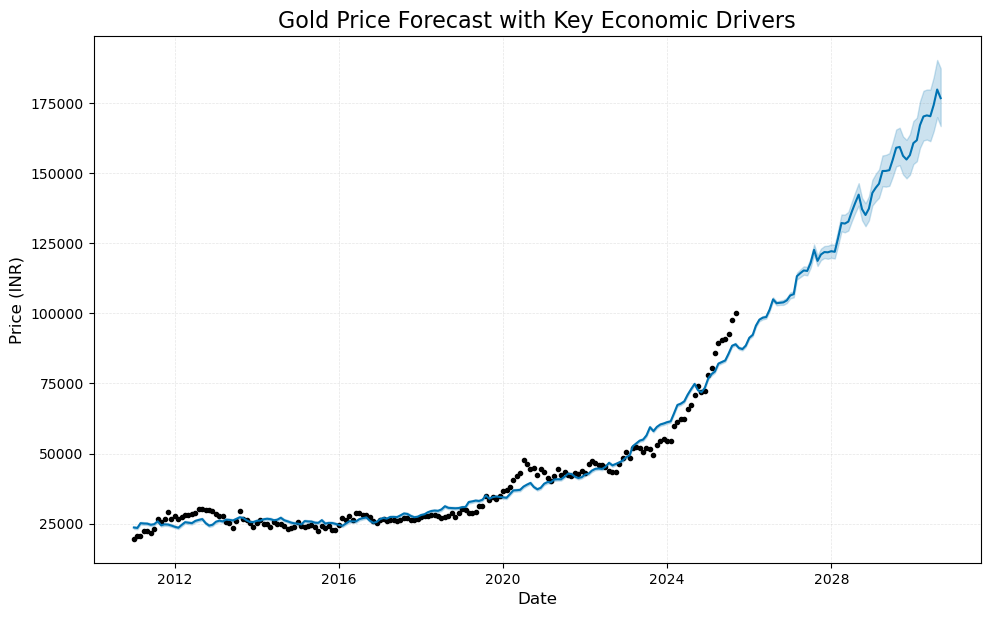

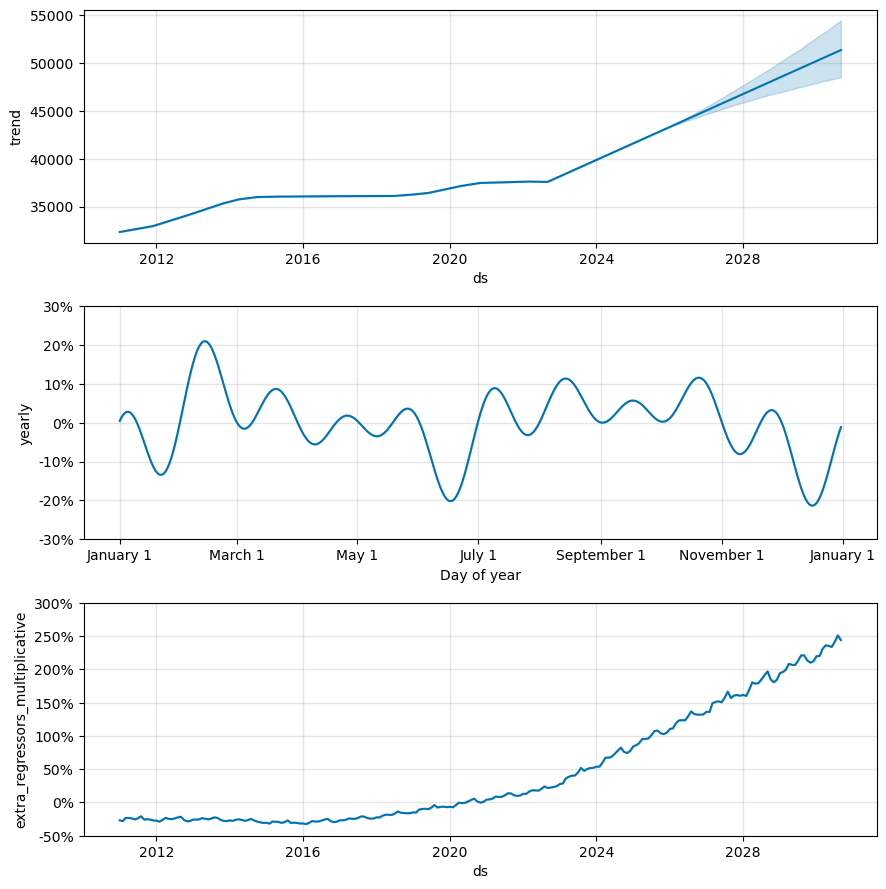

In [4]:
%pip install prophet

import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.serialize import model_to_json
import pickle # Import the pickle library
import matplotlib.pyplot as plt

# --- 1. Load and Prepare Data ---
# Update the path below to the correct location of your CSV file
df = pd.read_csv("gold_price_pred_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df.set_index('Date', inplace=True)

for col in ['GC_INR', 'GC_US_10g']:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '').astype(float)
if df['change_per_ind'].dtype == 'object':
    df['change_per_ind'] = df['change_per_ind'].str.replace('%', '').astype(float)

df.sort_index(inplace=True)

# --- 2. Forecast Regressors ---
print("Step 1: Forecasting the future of key economic drivers...")
future_steps = 60 # 5 years (60 months)
regressors_to_forecast = ['GC_US_10g', 'USD=INR', 'cpi_inflation_ind']
regressor_forecasts = {}

for regressor in regressors_to_forecast:
    print(f"  - Forecasting {regressor}...")
    regressor_df = df.reset_index()[['Date', regressor]].rename(columns={'Date': 'ds', regressor: 'y'})
    regressor_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    regressor_model.fit(regressor_df)
    future_regressor_df = regressor_model.make_future_dataframe(periods=future_steps, freq='MS')
    forecast = regressor_model.predict(future_regressor_df)
    regressor_forecasts[regressor] = forecast
print("Key driver forecasts complete.")

# --- 3. Prepare Data for the Main Model ---
prophet_df = df.reset_index()[['Date','GC_INR']].rename(columns={'Date':'ds','GC_INR':'y'})
for regressor in regressors_to_forecast:
    prophet_df[regressor] = df[regressor].values

# --- 4. Train the Main Prophet Model ---
print("\nStep 2: Training main model with multiple features...")
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)
for regressor in regressors_to_forecast:
    m.add_regressor(regressor)
m.fit(prophet_df)
print("Main model training complete.")

# --- 5. Generate Final Forecast ---
future = regressor_forecasts['GC_US_10g'][['ds']]
for regressor in regressors_to_forecast:
    future[regressor] = regressor_forecasts[regressor]['yhat']
forecast = m.predict(future)

# --- 6. Save Model and Data ---
print("\nStep 3: Saving model and data files...")

# Save the model as a pickle file (.pkl)
with open('gold_price_prophet_model.pkl', 'wb') as f:
    pickle.dump(m, f)
print(" - Model saved to 'gold_price_prophet_model.pkl'")

# Save the model as a JSON file (Prophet's native format)
with open('gold_price_prophet_model.json', 'w') as fout:
    fout.write(model_to_json(m))
print(" - Model saved to 'gold_price_prophet_model.json'")

# Save the input data to a JSON file
prophet_df.to_json('model_input_data.json', orient='records', date_format='iso')
print(" - Input data saved to 'model_input_data.json'")

# Save the final forecast (output) to a JSON file
forecast.to_json('model_output_forecast.json', orient='records', date_format='iso')
print(" - Forecast data saved to 'model_output_forecast.json'")


# --- 7. Plot the Final Forecast ---
print("\nStep 4: Plotting the final 5-year forecast...")
fig = m.plot(forecast)
plt.title('Gold Price Forecast with Key Economic Drivers', fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (INR)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

fig2 = m.plot_components(forecast)
plt.show()